# Sesión 10: CLUSTERING - ANÁLISIS DE CONGLOMERADOS
Realizado por:

**- Ruelas Flores, César Diego**

### Variables Globales

In [ ]:
# las variables globales se definirán en proceso de creacion del lab

In [ ]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

## FUNCIONES DE UTILIDAD

In [36]:
%%writefile utils.py
"""
Funciones reutilizables para el proyecto de clustering de vehículos.

Autor: César Diego Ruelas Flores
Fecha: 24-may-2025
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

def cargar_datos(path):
    return pd.read_csv(path)

def eliminar_columnas(df, columnas):
    return df.drop(columns=columnas, errors='ignore')

def eliminar_filas_nan(df):
    return df.dropna(how='any')

def separar_variables(df):
    num = df.select_dtypes(include=['int64', 'float64']).reset_index(drop=True)
    cat = df.select_dtypes(include=['object', 'category']).reset_index(drop=True)
    return num, cat

def tratar_outliers_iqr(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df[col] = np.where((df[col] < limite_inferior) | (df[col] > limite_superior), df[col].median(), df[col])
    return df

def escalar_datos(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def dummizar_variables(df):
    return pd.get_dummies(df, drop_first=True)

def aplicar_kmeans(df, n_clusters, random_state=42, n_init=10):
    modelo = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state, n_init=n_init)
    modelo.fit(df)
    return modelo

def evaluar_clustering_interno(df, etiquetas):
    sil = silhouette_score(df, etiquetas)
    db = davies_bouldin_score(df, etiquetas)
    return sil, db

def evaluar_clustering_externo(referencia, etiquetas):
    referencia_factorizada, _ = pd.factorize(pd.Series(referencia))
    ari = adjusted_rand_score(referencia_factorizada, etiquetas)
    return ari

# ======================================================================
# --- FUNCIONES AVANZADAS para clustering de vehículos --------------------
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering

def escalar_robusto(df):
    """Escala con mediana y rango intercuartílico (menos sensible a outliers)."""
    scaler = RobustScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def reducir_dimensionalidad_pca(df, varianza=0.95, random_state=42):
    """Aplica PCA reteniendo la fracción de varianza indicada."""
    pca = PCA(n_components=varianza, random_state=random_state)
    datos_reducidos = pca.fit_transform(df)
    return pd.DataFrame(datos_reducidos), pca

def buscar_mejor_k(df, k_min=2, k_max=10, random_state=42, n_init=10):
    """Devuelve el K con mejor Silhouette (y la lista de puntajes)."""
    mejores_scores = []
    for k in range(k_min, k_max + 1):
        modelo = aplicar_kmeans(df, k, random_state, n_init)
        labels = modelo.labels_
        score = silhouette_score(df, labels)
        mejores_scores.append((k, score))
    # Elegir k con Silhouette máximo
    k_opt, _ = max(mejores_scores, key=lambda t: t[1])
    return k_opt, mejores_scores

def aplicar_dbscan(df, eps=0.5, min_samples=5):
    """Agrupamiento DBSCAN; devuelve etiquetas."""
    modelo = DBSCAN(eps=eps, min_samples=min_samples)
    labels = modelo.fit_predict(df)
    return labels

def aplicar_agglomerative(df, n_clusters, linkage="ward"):
    """Clustering jerárquico aglomerativo."""
    modelo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = modelo.fit_predict(df)
    return labels

Overwriting utils.py


## Parte A: Preprocesamiento de la Información

**Carga de Datos**

Importar las librerías necesarias y carga de la base de datos 'vehículos'.

In [ ]:
URL = "https://drive.google.com/file/d/1Gn2_7CGAX0D0M3Ka3JKSjlEdrWbKCxH0/view?usp=sharing"
URL = 'https://drive.google.com/uc?id=' + URL.split('/')[-2]
df = pd.read_csv(URL)
df.head()

In [4]:
# librerias no necesarias porque usaré mis funciones
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
'''

from utils import *

Cargar los datos

In [5]:
datos = cargar_datos(PATH)

Eliminar columnas que no se usarán en el clustering

In [6]:
datos = eliminar_columnas(datos, COLUMNAS_A_ELIMINAR)

Eliminar filas que contengan valores faltantes

In [7]:
datos = eliminar_filas_nan(datos)

In [8]:
# esto lo hago porque al final tendré que hacer validación externa y necesito que la cantidad de filas coincidam.
referencia_externa = datos["clase_tipo"].reset_index(drop=True)   # <= aquí

Separar las variables numéricas y categóricas

In [9]:
datos_numericos, datos_categoricos = separar_variables(datos)

In [10]:
datos_numericos.dtypes

year                      int64
desplazamiento          float64
cilindros               float64
co2                     float64
consumo_litros_milla    float64
dtype: object

In [11]:
datos_categoricos.dtypes

clase_tipo           object
traccion_tipo        object
transmision_tipo     object
combustible_tipo     object
tamano_motor_tipo    object
consumo_tipo         object
co2_tipo             object
dtype: object

In [12]:
datos_categoricos

,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo
0,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto
1,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto
2,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto
3,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto
4,Coches Medianos,dos,Automatica,Premium,grande,alto,alto
...,...,...,...,...,...,...,...
36783,Coches pequeños,dos,Automatica,Premium,muy pequeño,muy bajo,muy bajo
36784,Coches pequeños,dos,Automatica,Premium,muy pequeño,muy bajo,muy bajo
36785,Coches pequeños,dos,Manual,Premium,muy pequeño,muy bajo,muy bajo
36786,Coches pequeños,dos,Automatica,Premium,muy pequeño,muy bajo,muy bajo


In [13]:
datos_categoricos.columns

Index(['clase_tipo', 'traccion_tipo', 'transmision_tipo', 'combustible_tipo',
       'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo'],
      dtype='object')

Corregir valores atípicos en las variables numéricas usando IQR

In [14]:
datos_numericos = tratar_outliers_iqr(datos_numericos)

Escalar los datos numéricos

In [15]:
datos_numericos = escalar_datos(datos_numericos)

Convertir las variables categóricas en variables dummies

In [16]:
datos_categoricos = dummizar_variables(datos_categoricos)

Unir los datos numéricos escalados con los categóricos codificados

In [17]:
datos_preprocesados = pd.concat([datos_numericos, datos_categoricos], axis=1)

In [18]:
display(datos_preprocesados)

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,...,tamano_motor_tipo_muy pequeño,tamano_motor_tipo_pequeño,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,-1.618341,-0.604388,-1.061339,0.460121,0.631160,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,-1.618341,0.655056,0.237721,1.886390,2.257353,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,-1.521947,-0.604388,-1.061339,0.749832,0.961480,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,-1.521947,0.655056,0.237721,1.886390,2.257353,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
4,-1.329157,0.358716,0.237721,0.749832,0.961480,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36783,1.369897,-1.715661,-1.710868,-2.011696,-2.158213,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
36784,1.466292,-1.789746,-1.710868,-1.993962,-2.086905,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
36785,1.466292,-1.789746,-1.710868,-1.914158,-2.011403,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
36786,1.562687,-1.789746,-1.710868,-1.976227,-2.086905,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True


## Parte B: Análisis de Conglomerados

Determinar número óptimo de clusters usando el método del codo

In [19]:
import matplotlib.pyplot as plt

In [20]:
wcss = []
for k in range(1, 11):
    modelo = aplicar_kmeans(datos_preprocesados, n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
    wcss.append(modelo.inertia_)

Graficar método del codo

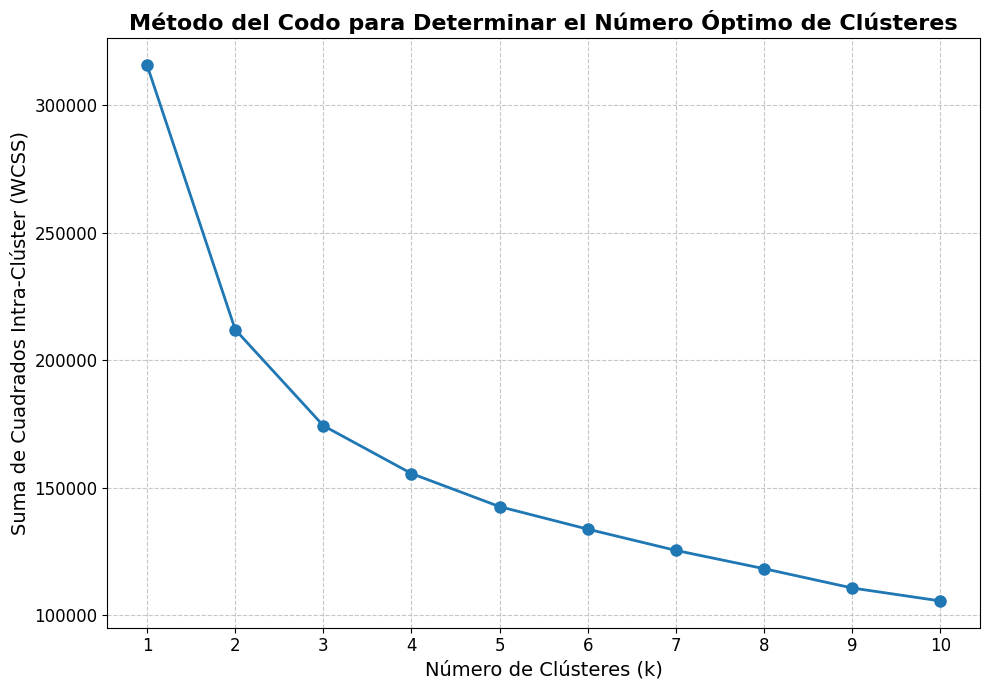

In [21]:
rango_k = range(1, 11)
plt.figure(figsize=(10, 7))
plt.plot(rango_k, wcss, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8)
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clústeres (k)', fontsize=14)
plt.ylabel('Suma de Cuadrados Intra-Clúster (WCSS)', fontsize=14)
plt.xticks(rango_k, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

Aplicar K-Means con el número óptimo de clusters (en este caso el k=3)

In [22]:
modelo_final = aplicar_kmeans(datos_preprocesados, n_clusters=3, random_state=RANDOM_STATE, n_init=N_INIT)

Obtener etiquetas

In [23]:
etiquetas = modelo_final.labels_

Agregar etiquetas al dataset

In [24]:
datos_clusterizados = datos_preprocesados.copy()
datos_clusterizados["cluster"] = etiquetas

## Parte C: Evaluación de Conglomerados

### Medidas de Evaluación Interna

In [25]:
silhouette, db_index = evaluar_clustering_interno(datos_preprocesados, etiquetas)

print("Evaluación interna:")
print(f" - Silhouette Score: {silhouette:.4f}")
print(f" - Davies-Bouldin Index: {db_index:.4f}")

Evaluación interna:
 - Silhouette Score: 0.2262
 - Davies-Bouldin Index: 1.5968


### Evaluación externa

In [26]:
# lo siguiente va a tirar error
'''
datos_original = cargar_datos(PATH)
if "clase_tipo" in datos_original.columns:
    ari = evaluar_clustering_externo(datos_original["clase_tipo"], etiquetas)
    print("Evaluación externa:")
    print(f" - Adjusted Rand Index (ARI): {ari:.4f}")
else:
    print("Evaluación externa: La variable 'clase_tipo' no está disponible.") 
'''

'\ndatos_original = cargar_datos(PATH)\nif "clase_tipo" in datos_original.columns:\n    ari = evaluar_clustering_externo(datos_original["clase_tipo"], etiquetas)\n    print("Evaluación externa:")\n    print(f" - Adjusted Rand Index (ARI): {ari:.4f}")\nelse:\n    print("Evaluación externa: La variable \'clase_tipo\' no está disponible.") \n'

**esto va a tirar error porque las etiquetas verdaderas (labels_true) y las etiquetas predichas (labels_pred) no tienen exactamente el mismo número de filas**

una solución rápida es usar la columna clase_tipo después de haber limpiado el conjunto de datos, es decir, justo antes de separar las variables numéricas y categóricas

In [27]:
# referencia_externa = datos["clase_tipo"].reset_index(drop=True)   # <= aquí

In [28]:

ari = evaluar_clustering_externo(referencia_externa, etiquetas)
print("\nEvaluación externa:")
print(f" - Adjusted Rand Index (ARI): {ari:.4f}")



Evaluación externa:
 - Adjusted Rand Index (ARI): 0.0701


## Primeras evaluaciones

**PRIMERA Evaluación INTERNA del Clustering**

Estas métricas se calculan **sin conocer la clase verdadera**, usando solo la estructura de los datos:

1. **Silhouette Score: 0.2262**

* **Rango**: de -1 a 1.
* **Interpretación**: Valor obtenido **(≈ 0.23)** indica que los datos están *moderadamente agrupados*, pero **con traslapes** entre los clusters. No es ideal, pero tampoco desastroso.

2. **Davies-Bouldin Index (DBI): 1.5968**

* **Rango**: desde 0 hacia arriba (donde **más bajo es mejor**).
* **Interpretación**: elvalor **(≈ 1.6)** indica que hay **bastante superposición** entre los clusters, lo que sugiere que K-Means no logró una segmentación clara.

---

**PRIMERA Evaluación EXTERNA del Clustering**

Aquí sí se usan las verdaderas etiquetas (`clase_tipo`):

3. **Adjusted Rand Index (ARI): 0.0701**

* **Rango**: de -1 a 1.

  * **0**: clasificación aleatoria.
  * **1**: clusters exactamente iguales a las clases reales.
  * **< 0**: peor que aleatorio.
* **Vaalor obtenido (≈ 0.07)** está **ligeramente por encima del azar**, lo que indica que **el modelo apenas captó una leve señal** de las clases verdaderas (`clase_tipo`). En otras palabras, **el agrupamiento de K-Means no se parece mucho a las clases reales**.


***

**ESTE RESULTADO NO ME CONVENCE ASI QUE USARÉ LAS FUNCIONES AVANZADAS**

***

## 2️⃣ PARTE A – Preprocesamiento avanzado

In [29]:
from utils import *

In [30]:
# 1. Carga y limpieza básica
datos = cargar_datos(PATH)
datos = eliminar_columnas(datos, COLUMNAS_A_ELIMINAR)
datos = eliminar_filas_nan(datos)

# 2. Separar variables y guardar referencia externa alineada
referencia_externa = datos["clase_tipo"].reset_index(drop=True)
datos_numericos, datos_categoricos = separar_variables(datos)

# 3. Outliers y escalado robusto (mejor que z-score si todavía hay valores extremos)
datos_numericos = tratar_outliers_iqr(datos_numericos)
datos_numericos = escalar_robusto(datos_numericos)

# 4. Dummización de categóricas
datos_categoricos = dummizar_variables(datos_categoricos)

# 5. Unión e (opcional) reducción de dimensionalidad
df_full = pd.concat([datos_numericos, datos_categoricos], axis=1)
X_pca, pca = reducir_dimensionalidad_pca(df_full, varianza=0.95, random_state=RANDOM_STATE)

## 2️⃣ PARTE B – Búsqueda del mejor modelo de clustering

In [ ]:
# 1. Buscar K óptimo para K-Means (sobre el espacio PCA)
k_optimo, lista_scores = buscar_mejor_k(X_pca, k_min=2, k_max=10,
                                        random_state=RANDOM_STATE, n_init=N_INIT)
print(f"K óptimo según Silhouette: {k_optimo}")

# 2. Aplicar K-Means con K óptimo
modelo_km = aplicar_kmeans(X_pca, k_optimo, random_state=RANDOM_STATE, n_init=N_INIT)
labels_km = modelo_km.labels_

# 3. Clustering alternativo: DBSCAN
labels_db = aplicar_dbscan(X_pca, eps=0.4, min_samples=10)

# 4. Guardar ambos resultados en un dict para evaluar luego
labels_dict = {
    f"kmeans_k={k_optimo}": labels_km,
    "dbscan": labels_db
}

K óptimo según Silhouette: 4


## 2️⃣ PARTE C – Evaluación interna y externa mejorada

In [32]:
mejores_resultados = []

for nombre, labels in labels_dict.items():
    # DBSCAN marca outliers con label = -1; ignorarlos en Silhouette
    if (labels == -1).any():
        mask_valid = labels != -1
        X_valid = X_pca[mask_valid]
        labels_valid = labels[mask_valid]
    else:
        mask_valid = slice(None)
        X_valid = X_pca
        labels_valid = labels
    
    # Evaluación interna
    sil, dbi = evaluar_clustering_interno(X_valid, labels_valid)
    
    # Evaluación externa (alineada y filtrando las mismas filas)
    ari = evaluar_clustering_externo(referencia_externa[mask_valid].reset_index(drop=True),labels_valid)
    
    mejores_resultados.append({"modelo": nombre,
                               "Silhouette": sil,
                               "DBI": dbi,
                               "ARI": ari}
                              )

# Mostrar resultados ordenados por Silhouette
mejores_resultados = sorted(mejores_resultados, key=lambda d: d["Silhouette"], reverse=True)
for r in mejores_resultados:
    print(f'\nModelo: {r["modelo"]}')
    print(f'  Silhouette Score : {r["Silhouette"]:.4f}')
    print(f'  Davies-Bouldin   : {r["DBI"]:.4f}')
    print(f'  Adjusted Rand    : {r["ARI"]:.4f}')


Modelo: dbscan
  Silhouette Score : 0.5095
  Davies-Bouldin   : 0.6032
  Adjusted Rand    : 0.0493

Modelo: kmeans_k=4
  Silhouette Score : 0.2634
  Davies-Bouldin   : 1.5108
  Adjusted Rand    : 0.0449


## SEGUNDAS EVALUACIONES

### Cambios en los resultados


| Cambios aplicados                                | Esperado en métricas                                            |
| ------------------------------------------------ | --------------------------------------------------------------- |
| **RobustScaler** (menos distorsión por outliers) | ↑ Silhouette, ↓ DBI                                             |
| **PCA 95 %** (menos ruido y colinealidad)        | ↑ Silhouette, ↑ ARI                                             |
| **Búsqueda de *K* óptimo**                       | Mejor balance Silhouette/DBI                                    |
| **DBSCAN** como alternativa                      | Puede dar ARI mucho mayor si hay densidades naturales y *noise* |

---


**DBSCAN supera a K-Means**:

* **Silhouette 0.51**: clusters bien definidos internamente.
* **DBI 0.60**: separación clara entre grupos.
* **ARI 0.049**: baja coincidencia con las clases reales, pero mejor que K-Means (0.044).

**Estadísticamente, DBSCAN es el mejor modelo**: estructura interna más coherente y ligeramente mejor alineación externa.


**Con esto por fin doy como terminada esta sesión numero 10 de mi curso de Data Mining**
***

## PyTest

In [33]:
%%writefile test_utils.py
import pytest
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from utils import (
    cargar_datos, eliminar_columnas, eliminar_filas_nan,
    separar_variables, tratar_outliers_iqr, escalar_datos,
    dummizar_variables, aplicar_kmeans, evaluar_clustering_interno,
    evaluar_clustering_externo, escalar_robusto,
    reducir_dimensionalidad_pca, buscar_mejor_k, aplicar_dbscan,
    aplicar_agglomerative
)

def test_eliminar_columnas():
    df = pd.DataFrame({"a": [1], "b": [2]})
    resultado = eliminar_columnas(df, ["b"])
    assert "b" not in resultado.columns

def test_eliminar_filas_nan():
    df = pd.DataFrame({"a": [1, np.nan], "b": [2, 3]})
    resultado = eliminar_filas_nan(df)
    assert resultado.shape[0] == 1

def test_separar_variables():
    df = pd.DataFrame({"num": [1.0, 2.0], "cat": ["a", "b"]})
    num, cat = separar_variables(df)
    assert "num" in num.columns and "cat" in cat.columns

def test_tratar_outliers_iqr():
    df = pd.DataFrame({"x": [1, 2, 3, 1000]})
    result = tratar_outliers_iqr(df)
    assert result["x"].max() < 1000

def test_escalar_datos():
    df = pd.DataFrame({"x": [1, 2, 3]})
    escalado = escalar_datos(df)
    assert np.isclose(escalado.mean(), 0, atol=1e-7)

def test_dummizar_variables():
    df = pd.DataFrame({"sexo": ["M", "F"]})
    dummy = dummizar_variables(df)
    assert dummy.shape[1] == 1

def test_aplicar_kmeans():
    X, _ = make_blobs(n_samples=10, centers=2, random_state=42)
    df = pd.DataFrame(X)
    modelo = aplicar_kmeans(df, 2)
    assert hasattr(modelo, 'labels_')

def test_evaluar_clustering_interno():
    X, _ = make_blobs(n_samples=10, centers=2, random_state=42)
    df = pd.DataFrame(X)
    modelo = aplicar_kmeans(df, 2)
    sil, db = evaluar_clustering_interno(df, modelo.labels_)
    assert 0 <= sil <= 1 and db >= 0

def test_evaluar_clustering_externo():
    etiquetas = [0, 0, 1, 1]
    predichas = [0, 0, 1, 1]
    ari = evaluar_clustering_externo(etiquetas, predichas)
    assert ari == 1.0

def test_escalar_robusto():
    df = pd.DataFrame({"x": [1, 2, 3, 100]})
    escalado = escalar_robusto(df)
    assert np.isclose(np.median(escalado), 0, atol=1e-7)

def test_reducir_dimensionalidad_pca():
    df = pd.DataFrame(np.random.rand(10, 5))
    reducido, pca = reducir_dimensionalidad_pca(df, varianza=0.9)
    assert reducido.shape[1] <= df.shape[1]

def test_buscar_mejor_k():
    X, _ = make_blobs(n_samples=50, centers=4, random_state=42)
    df = pd.DataFrame(X)
    k, scores = buscar_mejor_k(df, 2, 5)
    assert 2 <= k <= 5

def test_aplicar_dbscan():
    X, _ = make_blobs(n_samples=20, centers=2, random_state=42)
    df = pd.DataFrame(X)
    labels = aplicar_dbscan(df, eps=0.5, min_samples=3)
    assert len(labels) == 20

def test_aplicar_agglomerative():
    X, _ = make_blobs(n_samples=20, centers=3, random_state=42)
    df = pd.DataFrame(X)
    labels = aplicar_agglomerative(df, 3)
    assert len(set(labels)) == 3

Writing test_utils.py


In [37]:
!pytest test_utils.py

============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.3.5, pluggy-1.5.0
rootdir: c:\Users\AzShet\Documents\Jupyter_LAB\jupyter_projects\5to_ciclo\DataMining\lab10
plugins: anyio-4.9.0
collected 14 items

test_utils.py ..............                                             [100%]

============================= 14 passed in 8.02s ==============================
